# Machine Learning Pipeline - Feature Engineering

We will implement each of **the steps in the Machine Learning Pipeline**: Data Analysis, **Feature Engineering**, Feature Selection, Model Training, Obtaining Predictions / Scoring! We will use the house price dataset available on [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)!

**The aim of the project** is to build a machine learning model to predict the sale price of homes based on different explanatory variables describing aspects of residential houses. We aim to minimise the difference between the real price and the price estimated by our model. We will evaluate model performance with the: **mean squared error (mse)**. **root squared of the mean squared error (rmse)**, **r-squared (r2)**. 

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of **randomness**, it is extremely important that we **set the seed**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # for the yeo-johnson transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # feature scaling
import joblib  # to save the trained scaler class
pd.pandas.set_option('display.max_columns', None) # to visualise al the columns

**Load dataset and visualize!**

In [2]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Separate dataset into train and test

It is important to separate our data intro training and testing set. When we **engineer features**, some techniques learn parameters from data. It is important to **learn these parameters only from the train set**. This is to avoid **over-fitting.** Our feature engineering techniques will learn: **mean, mode, exponents for the yeo-johnson, category frequency, and category to number mappings** from the train set.

Separate the data into **train and test with randomness**, therefore, we need to set **the seed (random_state)**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0,)  # we are setting the seed here
X_train.shape, X_test.shape

((1314, 79), (146, 79))

# Feature Engineering

In the following cells, we will engineer the variables of the House Price Dataset so that we tackle: **Missing values! Temporal variables! Non-Gaussian distributed variables! Categorical variables: remove rare labels! Categorical variables: convert strings to numbers! Put the variables in a similar scale!**

## Target

**We apply the logarithm!**

In [4]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Missing values

### Categorical variables

We will replace **missing values** with the string "missing" in those variables with a **lot of missing data**. Alternatively, we will replace **missing data** with the **most frequent category** in those variables that contain **fewer observations without values**. This is common practice.

**Identify the categorical variables! Add MSSubClass to them. Because it is categorical.**

In [5]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['MSSubClass']
X_train[cat_vars] = X_train[cat_vars].astype('O')  # cast them as categorical
X_test[cat_vars] = X_test[cat_vars].astype('O')
len(cat_vars)

44

**List the categorical variables, those with missing values! Show them with their percentage!**

In [6]:
cat_vars_with_na = [var for var in cat_vars 
                    if X_train[var].isnull().sum() > 0]
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

**Variables to impute with the string missing and the most frequent category!**

In [7]:
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [8]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

**Replace missing values with new label: "Missing"!**

In [9]:
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

**Take modes of them. There can be more than 1 mode! Take the first!**

In [10]:
for var in with_frequent_category:
    mode = X_train[var].mode()[0]  
    print(var, mode)
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


**Check that we have no missing information in the engineered variables**

In [11]:
X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

**Check that test set does not contain null values in the engineered variables!**

In [12]:
[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical variables

**Identify the numerical variables! Add a binary missing indicator variable! then replace them with the mean!**

In [13]:
num_vars = [var for var in X_train.columns if var not in cat_vars and var != 'SalePrice']
len(num_vars)

35

**List the numerical variables that contain missing values! Then print their percentage!**

In [14]:
vars_with_na = [var for var in num_vars
                if X_train[var].isnull().sum() > 0]
X_train[vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

**Calculate the mean from the train set. Add binary missing indicator in train and test. Then replace missing values by the mean!**

In [15]:
for var in vars_with_na:
    mean_val = X_train[var].mean()
    print(var, mean_val)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)
X_train[vars_with_na].isnull().sum()  # check that we have no missing values!

LotFrontage 69.87974098057354
MasVnrArea 103.7974006116208
GarageYrBlt 1978.2959677419356


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

**Check that test set does not contain null values in the engineered variables!**

In [16]:
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

**Check the binary missing indicator variables!**

In [17]:
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


## Temporal variables

### Capture elapsed time

Capture the **time elapsed between those variables and the year** in which the house was sold. First start from **YrSold** variable!

In [18]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

In [19]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

**Drop YrSold**

In [20]:
X_train.drop(['YrSold'], axis=1, inplace=True)
X_test.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

Transform the **numerical variables, not normally distributed**, with the **logarightm**, to get a **more Gaussian-like distribution**!

In [21]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

**Check that test set does not contain null values in the engineered variables**

In [22]:
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_test[var].isnull().sum() > 0]

[]

**Same for train set!**

In [23]:
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_train[var].isnull().sum() > 0]

[]

### Yeo-Johnson transformation

The **yeo-johnson transformation** learns the **best exponent to transform** the variable. We learn it from the train set adn apply to test set. Let's apply the Yeo-Johnson transformation to **LotArea**.

In [24]:
X_train['LotArea'], param = stats.yeojohnson(X_train['LotArea'])
X_test['LotArea'] = stats.yeojohnson(X_test['LotArea'], lmbda=param)
print(param)

2022-02-05 22:16:45,114 [31216] WARNING  py.warnings:109: [JupyterRequire] C:\Users\husey\anaconda3\lib\site-packages\scipy\stats\morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))

2022-02-05 22:16:45,122 [31216] WARNING  py.warnings:109: [JupyterRequire] C:\Users\husey\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom

2022-02-05 22:16:45,122 [31216] WARNING  py.warnings:109: [JupyterRequire] C:\Users\husey\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)

2022-02-05 22:16:45,122 [31216] WARNING  py.warnings:109: [JupyterRequire] C:\Users\husey\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx -

-12.55283001172003


**Check absence of na in the train set!**

In [25]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

**Check absence of na in the test set !**

In [26]:
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize skewed variables

There were a few variables **very skewed**, we would **transform** those into **binary variables**, by **mapping them into 0 and 1** !

In [27]:
skewed = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
          '3SsnPorch', 'ScreenPorch', 'MiscVal']
for var in skewed:
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_test[var] = np.where(X_test[var]==0, 0, 1)

## Categorical variables

These are variables which values have an **assigned order**, related to **quality**. **Re-map strings to numbers, which determine quality**

In [28]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
             'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',]
for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [29]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
var = 'BsmtExposure'
X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [30]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
finish_vars = ['BsmtFinType1', 'BsmtFinType2']
for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [31]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
var = 'GarageFinish'
X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [32]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
var = 'Fence'
X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

**Check absence of na in the train set!**

In [33]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Removing Rare Labels

All values of categorical variables that are shared by **less than 1% of houses**, well be replaced by the string **"Rare"**.

**Capture all quality variables, then capture the remaining categorical variables! (those that we did not re-map)**

In [34]:
qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']
cat_others = [var for var in cat_vars if var not in qual_vars]
len(cat_others)

30

**Function finds the labels that are shared by more than a certain % of the houses in the dataset**

In [35]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index
for var in cat_others:   # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    print(var, frequent_ls)
    print()

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Missing', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Con

**Replace rare categories by the string "Rare"!**

In [36]:
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Encoding of categorical variables

Next, we **transform the strings of the categorical variables into numbers** to capture the **monotonic relationship** between the label and the target.

This function will assign **discrete values** to the **strings of the variables**, so that **the smaller value** corresponds to t**he category that shows the smaller mean house sale price**! Order **the categories in a variable** from that with the lowest house sale price, to that with the highest! Create a dictionary of ordered categories to integer values!

In [37]:
def replace_categories(train, test, y_train, var, target):
    tmp = pd.concat([X_train, y_train], axis=1)
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    print(var, ordinal_label)
    print()
    train[var] = train[var].map(ordinal_label) # Replace the categorical strings by dictionary!
    test[var] = test[var].map(ordinal_label)

In [38]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, 'SalePrice')

MSZoning {'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Grvl': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape {'Reg': 0, 'IR1': 1, 'IR3': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'NoSeWa': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'FR3': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Sev': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NridgHt': 23, 'NoRidge': 24}

Condition1 {'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'PosN': 6, 'PosA': 7, 'RRNn': 8}

Condition2 {'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'Norm': 3, 'RRAe': 4, 'PosN': 5, 'PosA': 6}

BldgType {'2fmCon': 0, 'Dupl

**Check absence of na in the train set!**

In [39]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

**Check absence of na in the test set!**

In [40]:
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

['Condition2']

We can see **monotonic relationship** between labels and target! Function plots **median house sale price** per encoded category!

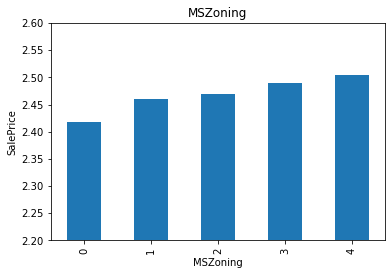

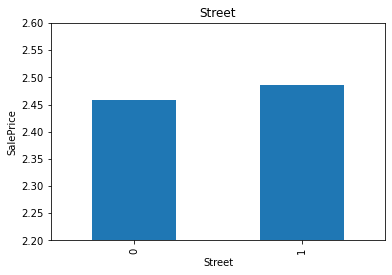

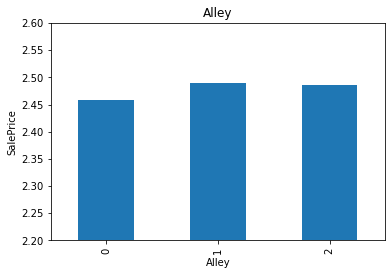

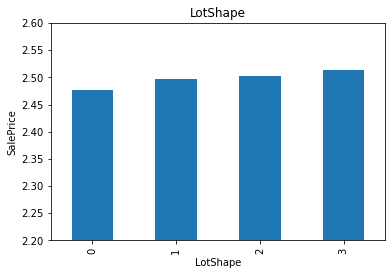

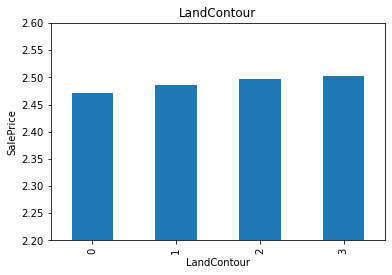

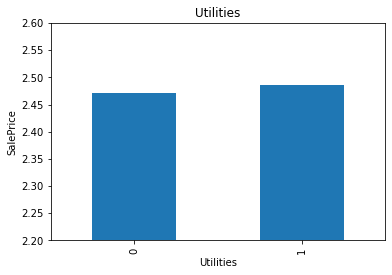

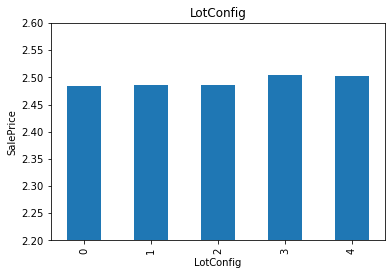

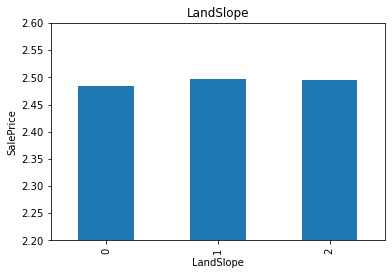

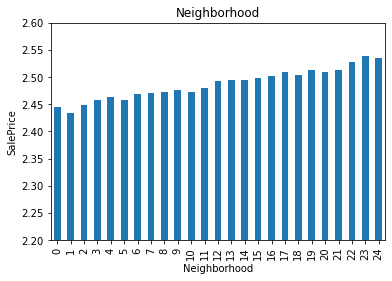

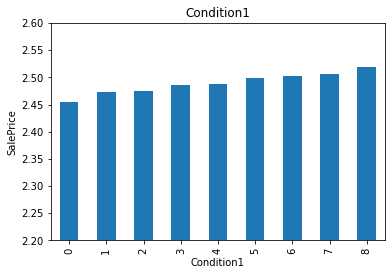

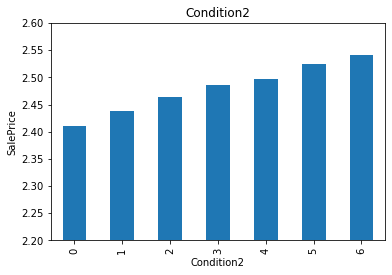

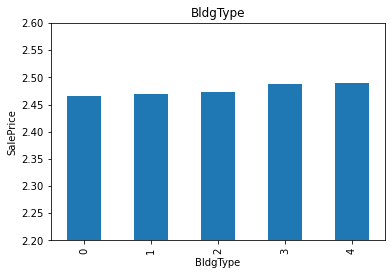

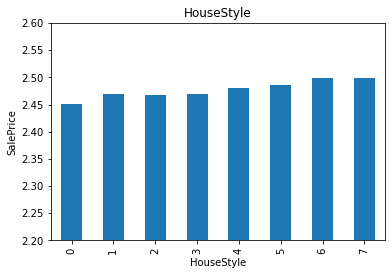

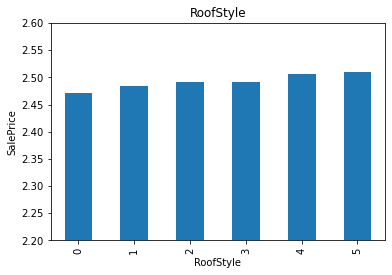

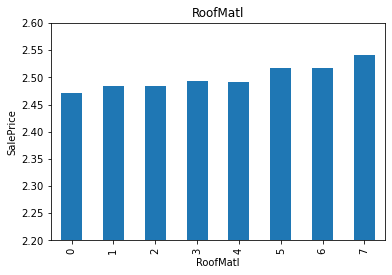

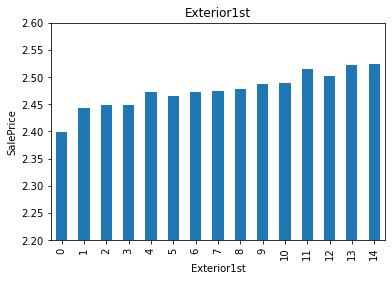

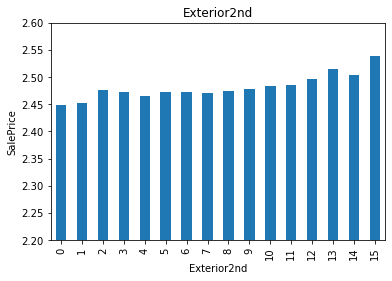

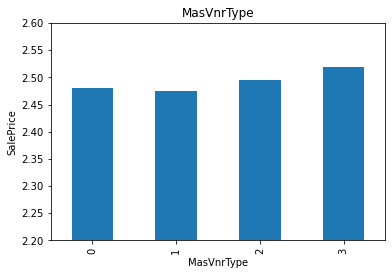

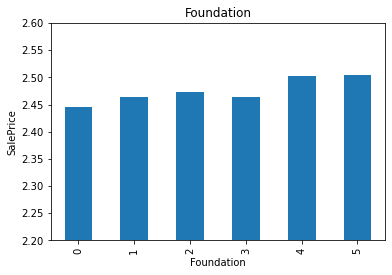

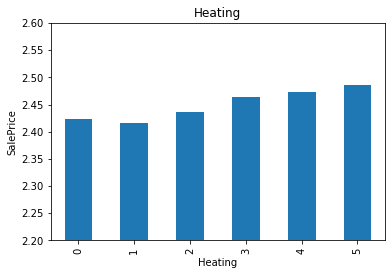

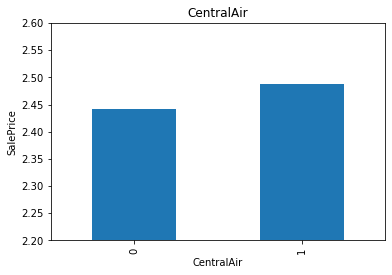

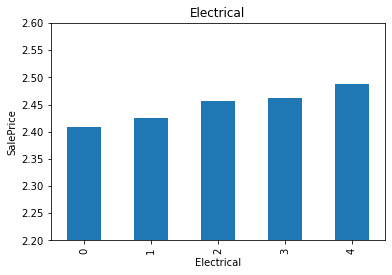

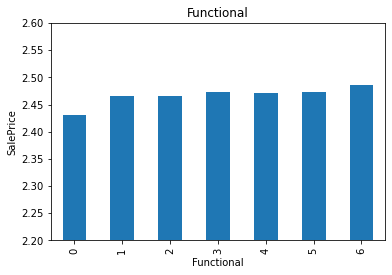

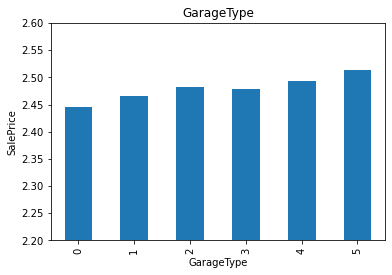

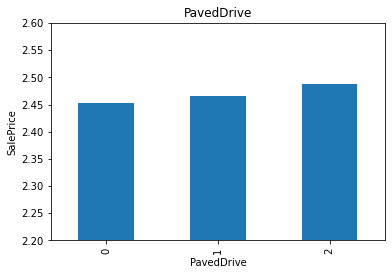

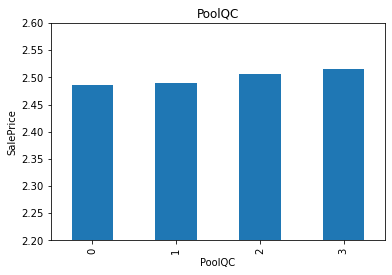

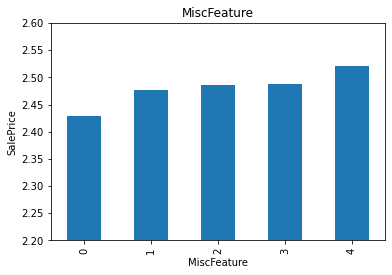

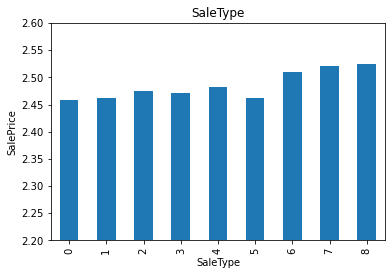

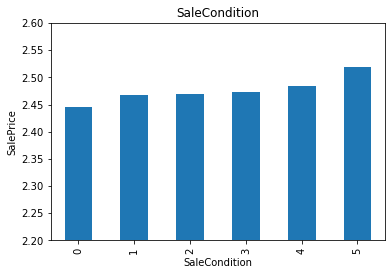

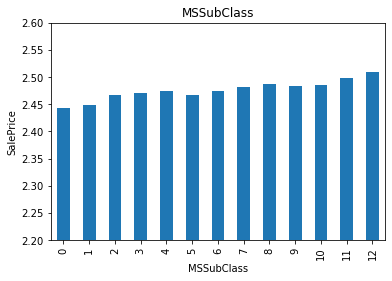

In [41]:
def analyse_vars(train, y_train, var):
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    tmp.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
for var in cat_others:
    analyse_vars(X_train, y_train, var)

The **monotonic relationship** is particularly clear for the variables **MSZoning and Neighborhood.** Note how, the higher the integer that now represents the category, the higher the mean house sale price. (remember that **the target is log-transformed**, that is **why the differences seem so small**).

## Feature Scaling

**In linear models, features need to be scaled. Scale features to the minimum and maximum values:**

**Create scaler! Fit the scaler to the train set! Sklearn returns numpy arrays, cast to df!**

In [42]:
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [43]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.461171,0.0,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.875000,0.375,0.5,0.75,0.571429,0.777778,0.50,0.014706,0.049180,0.2,0.285714,0.857143,0.933333,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.8,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,0.545455,0.5,0.8,0.0,0.0,0.0
1,0.750000,0.75,0.456066,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.416667,0.375,0.5,0.75,0.571429,0.444444,0.75,0.360294,0.049180,0.2,0.285714,0.571429,0.600000,0.666667,0.03375,0.666667,0.5,0.4,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.8,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,0.5,0.0,0.636364,0.5,0.8,0.0,0.0,0.0
2,0.916667,0.75,0.394699,0.0,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.958333,0.375,0.5,1.00,0.571429,0.888889,0.50,0.036765,0.098361,0.6,0.285714,0.428571,0.400000,0.666667,0.25750,1.000000,0.5,1.0,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.8,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,0.090909,0.5,0.8,0.0,0.0,0.0
3,0.750000,0.75,0.445002,0.0,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.500000,0.375,0.5,0.75,0.571429,0.666667,0.50,0.066176,0.163934,0.2,0.285714,0.857143,0.933333,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.8,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,0.636364,0.5,0.8,1.0,0.0,0.0
4,0.750000,0.75,0.577658,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.416667,0.375,0.5,0.75,0.571429,0.555556,0.50,0.323529,0.737705,0.2,0.285714,0.571429,0.666667,0.666667,0.17000,0.333333,0.5,0.4,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.8,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,0.5,0.0,0.545455,0.5,0.8,0.0,0.0,0.0


**Save the train and test sets for the next notebook!**

In [44]:
X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)
y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)

**Now let's save the scaler!**

In [45]:
joblib.dump(scaler, 'minmax_scaler.joblib') 

['minmax_scaler.joblib']

That concludes the feature engineering section.